In [ ]:
%pip install datasets huggingface-hub
!pip uninstall -y preprocessor
!pip uninstall -y tweet-preprocessor
!pip install tweet-preprocessor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import preprocessor as p
import nltk
import warnings
from bs4 import XMLParsedAsHTMLWarning
import pandas as pd
import datasets
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
distilbert_path = "notshivain1/distilbert-base-uncased-stackoverflow-prediction-V2"
roberta_path="krimson1/roberta-base-stackoverflow-prediction"
albert_path='notshivain1/albert-base-v1-stackoverflow-prediction'
bert_path='krimson1/bert-base-stackoverflow-prediction'

In [ ]:
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_path)
distilbert = AutoModelForSequenceClassification.from_pretrained(distilbert_path).to(device)

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_path)
roberta = AutoModelForSequenceClassification.from_pretrained(roberta_path).to(device)

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
albert_tokenizer = AutoTokenizer.from_pretrained(albert_path)
albert = AutoModelForSequenceClassification.from_pretrained(albert_path).to(device)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained(bert_path)
bert = AutoModelForSequenceClassification.from_pretrained(bert_path).to(device)

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Labels mapping
id2label={0:'LQ_CLOSE',1:'HQ',2:'LQ_EDIT'}
label2id={'LQ_CLOSE':0,'HQ':1,'LQ_EDIT':2}


In [ ]:
df=pd.read_csv("df_preprocessed.csv")
df=df.head(5000)

In [ ]:
def distilbert_preprocess_texts(examples):
    tokens = distilbert_tokenizer(
        examples["cleaned_text"], truncation=True, padding="max_length"
    )
    tokens["labels"] = [label2id[label] for label in examples["Y"]]
    return tokens

In [ ]:
def roberta_preprocess_texts(examples):
    tokens = roberta_tokenizer(
        examples["cleaned_text"], truncation=True, padding="max_length"
    )
    tokens["labels"] = [label2id[label] for label in examples["Y"]]
    return tokens

In [ ]:
def albert_preprocess_texts(examples):
    tokens = albert_tokenizer(
        examples["cleaned_text"], truncation=True, padding="max_length"
    )
    tokens["labels"] = [label2id[label] for label in examples["Y"]]
    return tokens

In [ ]:
def bert_preprocess_texts(examples):
    tokens = bert_tokenizer(
        examples["cleaned_text"], truncation=True, padding="max_length"
    )
    tokens["labels"] = [label2id[label] for label in examples["Y"]]
    return tokens

In [ ]:
dataset = datasets.Dataset.from_pandas(df)
dtokenized_data = dataset.map(distilbert_preprocess_texts, batched=True, remove_columns=["cleaned_text", "Y"])
rtokenized_data = dataset.map(roberta_preprocess_texts, batched=True, remove_columns=["cleaned_text", "Y"])
atokenized_data = dataset.map(albert_preprocess_texts, batched=True, remove_columns=["cleaned_text", "Y"])
btokenized_data = dataset.map(bert_preprocess_texts, batched=True, remove_columns=["cleaned_text", "Y"])

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
batch_size = 256
dpredicted_labels, rpredicted_labels, apredicted_labels, bpredicted_labels = [],[],[],[]


In [ ]:
for i in tqdm(range(0, len(atokenized_data), batch_size)):
    batch_input = {
        "input_ids": torch.tensor(atokenized_data["input_ids"][i:i+batch_size]).to(device),
        "attention_mask": torch.tensor(atokenized_data["attention_mask"][i:i+batch_size]).to(device),
    }

    with torch.no_grad():
        outputs = albert(**batch_input)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    apredicted_labels.extend(torch.argmax(probs, dim=-1).tolist())



100%|██████████| 20/20 [03:02<00:00,  9.12s/it]


In [ ]:

for i in tqdm(range(0, len(dtokenized_data), batch_size)):
    batch_input = {
        "input_ids": torch.tensor(dtokenized_data["input_ids"][i:i+batch_size]).to(device),
        "attention_mask": torch.tensor(dtokenized_data["attention_mask"][i:i+batch_size]).to(device),
    }

    with torch.no_grad():
        outputs = distilbert(**batch_input)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    dpredicted_labels.extend(torch.argmax(probs, dim=-1).tolist())



100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


In [ ]:
for i in tqdm(range(0, len(rtokenized_data), batch_size)):
    batch_input = {
        "input_ids": torch.tensor(rtokenized_data["input_ids"][i:i+batch_size]).to(device),
        "attention_mask": torch.tensor(rtokenized_data["attention_mask"][i:i+batch_size]).to(device),
    }

    with torch.no_grad():
        outputs = roberta(**batch_input)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    rpredicted_labels.extend(torch.argmax(probs, dim=-1).tolist())

100%|██████████| 20/20 [02:54<00:00,  8.70s/it]


In [ ]:
for i in tqdm(range(0, len(btokenized_data), batch_size)):
    batch_input = {
        "input_ids": torch.tensor(btokenized_data["input_ids"][i:i+batch_size]).to(device),
        "attention_mask": torch.tensor(btokenized_data["attention_mask"][i:i+batch_size]).to(device),
    }

    with torch.no_grad():
        outputs = bert(**batch_input)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    bpredicted_labels.extend(torch.argmax(probs, dim=-1).tolist())

100%|██████████| 20/20 [03:03<00:00,  9.17s/it]


In [ ]:
df["roberta_predicted_label"] = rpredicted_labels
df["distilbert_predicted_label"] = dpredicted_labels
df["albert_predicted_label"] = apredicted_labels
df["bert_predicted_label"] = bpredicted_labels

In [ ]:
df['Y']=df['Y'].map(label2id)

In [ ]:
dreport = classification_report(df["Y"], df["distilbert_predicted_label"], target_names=id2label.values())
rreport = classification_report(df["Y"], df["roberta_predicted_label"], target_names=id2label.values())
areport = classification_report(df["Y"], df["albert_predicted_label"], target_names=id2label.values())
breport = classification_report(df["Y"], df["bert_predicted_label"], target_names=id2label.values())

In [ ]:
print(dreport)

              precision    recall  f1-score   support

    LQ_CLOSE       0.81      0.94      0.87      1689
          HQ       0.95      0.81      0.88      1973
     LQ_EDIT       1.00      1.00      1.00      1338

    accuracy                           0.91      5000
   macro avg       0.92      0.92      0.91      5000
weighted avg       0.91      0.91      0.91      5000



In [ ]:
print(rreport)

              precision    recall  f1-score   support

    LQ_CLOSE       0.75      0.92      0.83      1689
          HQ       0.92      0.75      0.83      1973
     LQ_EDIT       0.98      0.97      0.97      1338

    accuracy                           0.87      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.87      0.87      5000



In [ ]:
print(areport)

              precision    recall  f1-score   support

    LQ_CLOSE       0.82      0.86      0.84      1689
          HQ       0.88      0.84      0.86      1973
     LQ_EDIT       0.99      0.99      0.99      1338

    accuracy                           0.89      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.89      0.89      0.89      5000



In [ ]:
print(breport)

              precision    recall  f1-score   support

    LQ_CLOSE       0.87      0.95      0.91      1689
          HQ       0.95      0.88      0.92      1973
     LQ_EDIT       1.00      0.99      1.00      1338

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



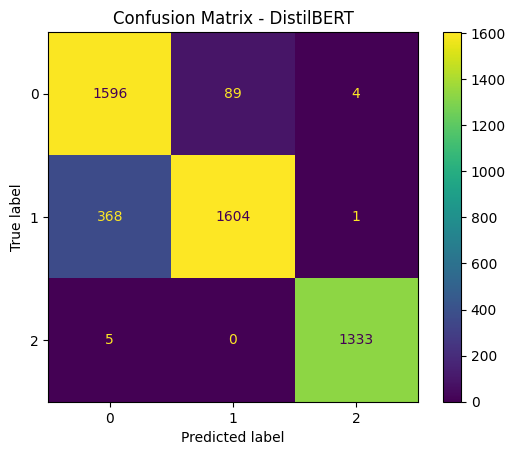

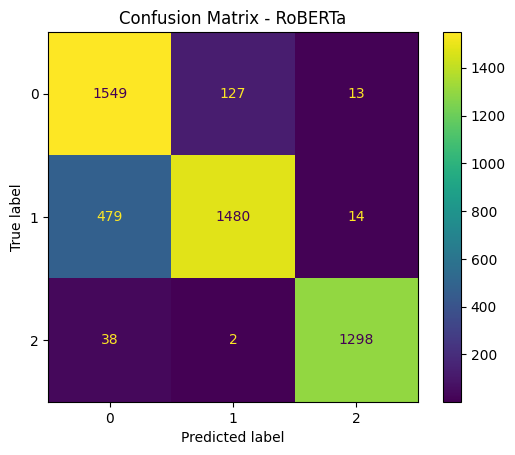

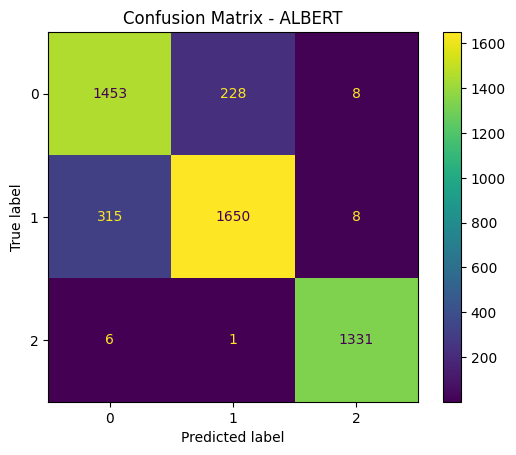

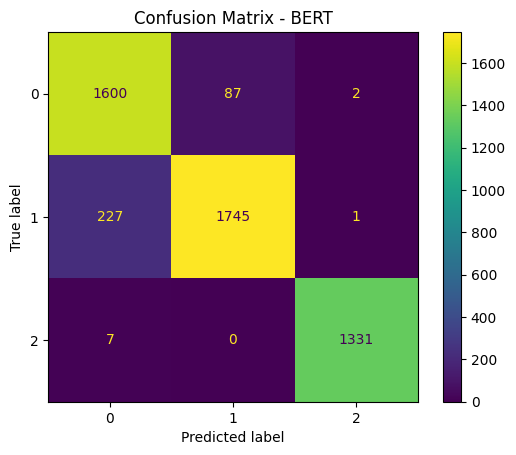

In [ ]:
cm1 = confusion_matrix(df["Y"], df["distilbert_predicted_label"])
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot()
plt.title("Confusion Matrix - DistilBERT")
plt.show()

cm2 = confusion_matrix(df["Y"], df["roberta_predicted_label"])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot()
plt.title("Confusion Matrix - RoBERTa")
plt.show()

cm3 = confusion_matrix(df["Y"], df["albert_predicted_label"])
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp3.plot()
plt.title("Confusion Matrix - ALBERT")
plt.show()

cm4 = confusion_matrix(df["Y"], df["bert_predicted_label"])
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4)
disp4.plot()
plt.title("Confusion Matrix - BERT")
plt.show()


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Text preprocessing
def cleanse(concat_text):
    concat_text = concat_text.lower()
    concat_text = re.sub(r'[^(a-zA-Z)\s]','', concat_text)
    concat_text = [word for word in concat_text.split() if word not in stopwords.words('english')]
    sentence = []
    for word in concat_text:
        lemmatizer = WordNetLemmatizer()
        word = p.clean(word)
        sentence.append(lemmatizer.lemmatize(word, 'v'))
    return ' '.join(sentence)

In [ ]:
# Sample input
sample_title = "What is the difference between 'git pull' and 'git fetch'?"
sample_body = "I accidentally committed the wrong files to Git but haven't pushed the commit to the server yet. How do I undo those commits from the local repository?"
concat_text = sample_title + ' ' + sample_body

In [ ]:
cleaned_text = cleanse(concat_text)
cleaned_text

'difference git pull git fetch accidentally commit wrong file git havent push commit server yet undo commit local repository'

In [ ]:
def predict(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_label_id = torch.argmax(probs, dim=-1).item()
    predicted_label = id2label[predicted_label_id]
    return predicted_label, probs.cpu().numpy()[0]

In [ ]:
distilbert_pred, distilbert_probs = predict(cleaned_text, distilbert_tokenizer, distilbert)
print("DistilBERT Prediction:", distilbert_pred)
print("DistilBERT Probabilities:", distilbert_probs)

roberta_pred, roberta_probs = predict(cleaned_text, roberta_tokenizer, roberta)
print("RoBERTa Prediction:", roberta_pred)
print("RoBERTa Probabilities:", roberta_probs)

albert_pred, albert_probs = predict(cleaned_text, albert_tokenizer, albert)
print("ALBERT Prediction:", albert_pred)
print("ALBERT Probabilities:", albert_probs)

bert_pred, bert_probs = predict(cleaned_text, bert_tokenizer, bert)
print("BERT Prediction:", bert_pred)
print("BERT Probabilities:", bert_probs)

DistilBERT Prediction: LQ_EDIT
DistilBERT Probabilities: [1.4489408e-03 9.1874518e-04 9.9763238e-01]
RoBERTa Prediction: LQ_EDIT
RoBERTa Probabilities: [0.00225061 0.00110396 0.9966454 ]
ALBERT Prediction: LQ_EDIT
ALBERT Probabilities: [0.00242614 0.00278784 0.99478596]
BERT Prediction: LQ_EDIT
BERT Probabilities: [6.2986155e-04 1.1168732e-03 9.9825329e-01]
